  Маркетологи одного из фитнес-центров запустили акцию "Набегай на абонемент". Чтобы оценить, какой эффект коммуникация оказала на суммарную дистанцию клиентов на беговой дорожке (признак kms), было решено провести А/Б тестирование. Для этого выделили две группы (находятся в файлах group_a.csv и group_b.csv). Коммуникацию отправляли только клиентам из группы b. Ваша задача - оценить успехи маркетологов (в проведении теста).



**Задачи:**

  Проанализировать результаты теста: как изменилось количество километров у клиентов, которым отправили коммуникацию?

  Сделать это
  
      а) с помощью t-теста (используя функцию scipy.stats.ttest_ind)
  
      б) с помощью бутстрапа 

  Определить минимальный размер эффекта, который можно задетектировать на данных группах при уровне значимости 0.05 и мощности 0.8. Сделать это двумя способами:
  
      а) используя функцию statsmodels.stats.power.tt_ind_solve_power 
      б) по формуле MDE. 


In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import t
from statsmodels.stats.power import tt_ind_solve_power

In [233]:
# загрузим имеющиеся данные
data = pd.read_csv('data.csv')
group_a = pd.read_csv('group_a.csv')
group_b = pd.read_csv('group_b.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  4000 non-null   int64  
 1   kms      4000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 62.6 KB


In [234]:
#распределим километраж по участникам групп
group_a_data = group_a.merge(data, how = 'left', on = 'user_id')
group_b_data = group_b.merge(data, how = 'left', on = 'user_id' )

print(f'Группа а \n{group_a_data.describe()}\n')
print(f'Группа б \n{group_b_data.describe()}')

Группа а 
            user_id          kms
count   2000.000000  2000.000000
mean   54828.915000    50.515335
std    26259.648833    28.858953
min    10001.000000     0.000000
25%    31436.500000    25.010000
50%    54136.500000    52.010000
75%    77708.250000    74.975000
max    99990.000000   102.160000

Группа б 
            user_id          kms
count   2000.000000  2000.000000
mean   54571.916500    50.815185
std    26462.023423    29.418566
min    10145.000000     0.000000
25%    31017.500000    24.942500
50%    53942.500000    50.920000
75%    77959.000000    76.900000
max    99955.000000   103.710000


In [235]:
print(f'Группа а \n{group_a_data.info()}\n')
print(f'Группа б \n{group_b_data.info()}')
##видим что NULL по выборкам нет, поэтому можем начинать

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  2000 non-null   int64  
 1   kms      2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 46.9 KB
Группа а 
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  2000 non-null   int64  
 1   kms      2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 46.9 KB
Группа б 
None


## Описательный анализ на графиках

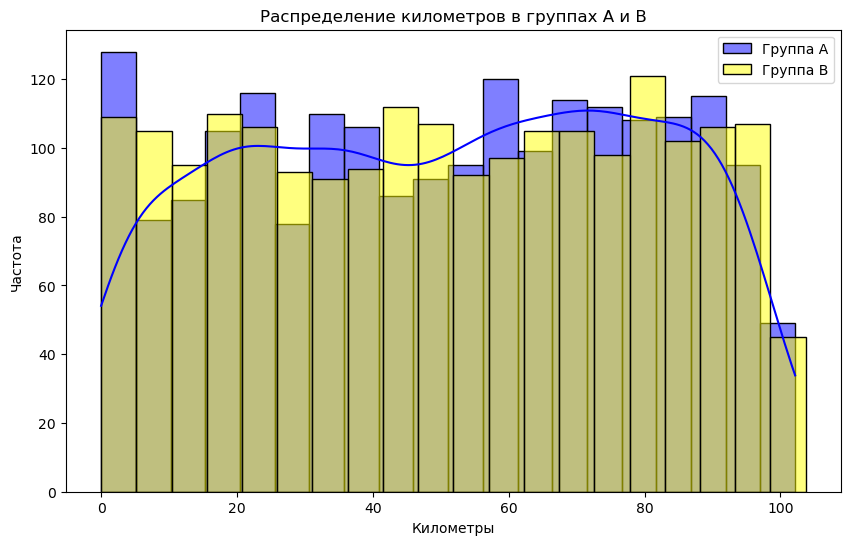

In [236]:
#построим гистограмму распределения и ящик с усами, чтобы посмотреть наличие выбросов и других аномалий
plt.figure(figsize=(10, 6))
sns.histplot(group_a_data['kms'], label='Группа A', bins = 20, kde=True, color='blue', alpha=0.5)
sns.histplot(group_b_data['kms'], label='Группа B', bins = 20, color='yellow', alpha=0.5)
plt.title('Распределение километров в группах A и B')
plt.xlabel('Километры')
plt.ylabel('Частота')
plt.legend()
plt.show()

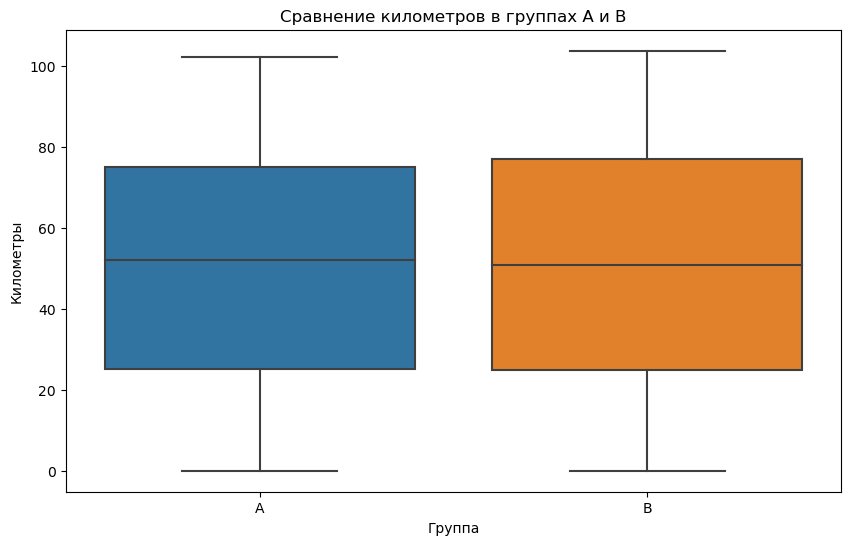

In [237]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='group', y='kms', data=pd.concat([
    group_a_data.assign(group='A'),
    group_b_data.assign(group='B')
]))
plt.title('Сравнение километров в группах A и B')
plt.xlabel('Группа')
plt.ylabel('Километры')
plt.show()

Из полученных графиков можем сделать 2 вывода:
1) данные распределены нормально
2) выбросы отсутствуют
 

## Проанализируем результаты теста: как изменилось количество километров у клиентов, которым отправили коммуникацию?

#### Выберем метрику и сформулируем гипотезу

Поскольку данные распределены нормально, то мы можем воспользоваться стандартным T-тестом для **средних значений**, а также проверим бутстрапом **разницу средних** на выборке из 1000 сэмплов

Сформулируем **гипотезы**:

Нулевая гипотеза (H0): Разница средних между двумя выборками равна нулю (нет значимой разницы).

Альтернативная гипотеза (H1): Разница средних между двумя выборками не равна нулю (есть значимая разница).

Кроме того, зададим уровень значимости a = 0.05

### T-тест

In [238]:
t_stat, p_value = ttest_ind(group_a_data['kms'], group_b_data['kms'])
print(f't-статистика = {round(t_stat, 2)}\np-значение = {round(p_value, 2)}\n')

#p-value больше уровня значимости 0.05, поэтому мы не можем отвергнуть гипотезу, разница не является статистически значимой

t-статистика = -0.33
p-значение = 0.74



### Bootstrap

In [239]:
#создадим функцию бутстрапа для 1000 итераций
def bootstrap_diff(group_a_data, group_b_data, n=1000):
    #создаем пустой список
    diff_means = []
    #для каждой итерации генерируем выборки с повторениями из имеющихся групп а и б
    for _ in range(n):
        sample_a = np.random.choice(group_a_data, size=len(group_a), replace=True)
        sample_b = np.random.choice(group_b_data, size=len(group_b), replace=True)
        #находим разницу между средним в выборках и добавляем в список
        diff_means.append(np.mean(sample_b) - np.mean(sample_a))
    return diff_means

# Применяем функцию к нашим выборкам
diff_means = bootstrap_diff(group_a_data['kms'], group_b_data['kms'], 1000)

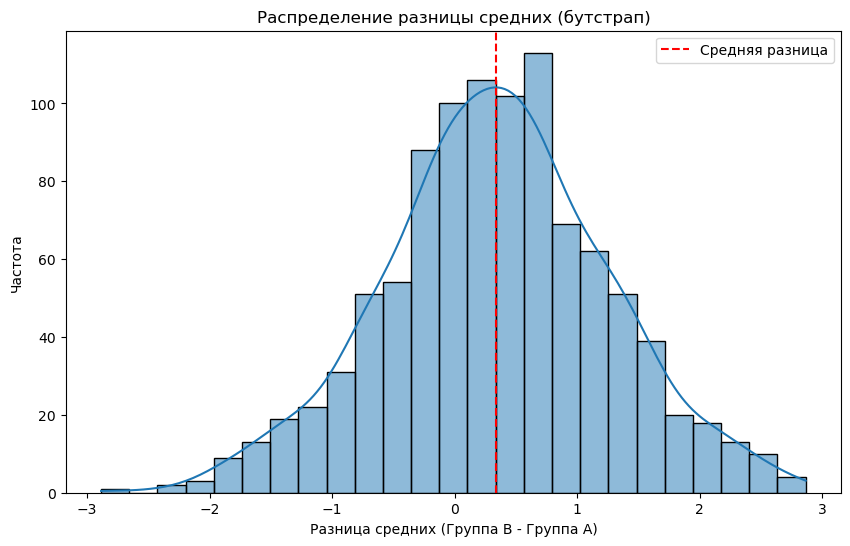

In [240]:
# Визуализируем распределение разницы средних
plt.figure(figsize=(10, 6))
sns.histplot(diff_means, kde=True)
plt.axvline(np.mean(diff_means), color='red', linestyle='--', label='Средняя разница')
plt.title('Распределение разницы средних (бутстрап)')
plt.xlabel('Разница средних (Группа B - Группа A)')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [241]:
#вычислим стандартную ошибку
standard_error = np.std(diff_means, ddof=1)
print(f"Стандартная ошибка среднего: {round(standard_error, 3)}\n")

# Доверительный интервал
confidence_interval_start, confidence_interval_end = np.percentile(diff_means, [2.5, 97.5])
print(f"95% доверительный интервал для разницы средних: [{round(confidence_interval_start, 2)} : {round(confidence_interval_end, 2)}]")

Стандартная ошибка среднего: 0.916

95% доверительный интервал для разницы средних: [-1.52 : 2.18]


#### Так как доверительный интервал содержит в себе 0, мы не можем считать разницу средних статистически значимой как и в T-тесте и не можем отклонить нуkевую гипотезу

## Определим минимальный размер эффекта, который можно задетектировать на данных группах при уровне значимости 0.05 и мощности 0.8

### Используем функцию statsmodels.stats.power.tt_ind_solve_power

In [242]:
#зададим параметры для формулы
#оставляем пустым, его нужно найти
effect_size = None
#уровень значимости (ошибка 1 рода)
alpha = 0.05
#мощность (1-b, где и - ошибка 2 рода)
power = 0.8
#размеры групп
size_a = len(group_a)
size_b = len(group_b)
ratio = size_b / size_a
#расчет дисперсии
var_a = np.var(group_a_data['kms'], ddof = 1)
var_b = np.var(group_b_data['kms'], ddof = 1)

# Вычисление минимального размера эффекта
effect_size = tt_ind_solve_power(effect_size=effect_size, nobs1=size_a, alpha=alpha, power=power, ratio=ratio)
print(f"Минимальный размер эффекта: {round(effect_size, 3)} стандартных отклонений")

Минимальный размер эффекта: 0.089 стандартных отклонений


#переведем размер эффекта в километры где mde_km = effect_size * s, где s - объединенное стандартное отклонение

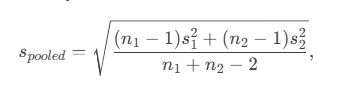


In [243]:
s = np.sqrt(((size_a - 1) * var_a + (size_b - 1) * var_b) / (size_a + size_b - 2))
mde_stats = s * effect_size
print(f'минимальный размер эффекта по формуле statsmodels.stats.power.tt_ind_solve_power: {round(mde_stats, 3)}км')

минимальный размер эффекта по формуле statsmodels.stats.power.tt_ind_solve_power: 2.582км


### Расчитаем по формуле MDE
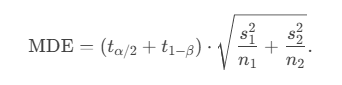

tα/2 - критическое значение t-распределения для уровня значимости α для двухстороннего теста

t1−β - критическое значение t-распределения для мощности 1−β

s1^2 и s2^2 — дисперсии двух выборок

n1 и n2 — размеры двух выборок

In [244]:
#уровень значимости
alpha_2 = 0.05
#мощность
power_2 = 0.8
#вероятность ошибки 2 рода
beta_2 = 1 - power_2
#размер выборок
size_a_2 = len(group_a)
size_b_2 = len(group_b)
#число степеней свободы
df = size_a_2 + size_b_2 - 2

#расчет квантилей
q_alpha = 1 - alpha_2 / 2  # Для двустороннего теста
q_power = 1 - beta_2       # Для мощности
#расчет значений t
t_alpha = t.ppf(q_alpha, df)
t_power = t.ppf(q_power, df)
#расчет дисперсии
var_a_2 = np.var(group_a_data['kms'], ddof = 1)
var_b_2 = np.var(group_b_data['kms'], ddof = 1)

print(f't_alpha: {round(t_alpha, 2)}\nt_power: {round(t_power, 2)}\n')

print(f'дисперсия группы a: {round(var_a_2, 2)}\nдисперсия группы б: {round(var_b_2, 2)}')

t_alpha: 1.96
t_power: 0.84

дисперсия группы a: 832.84
дисперсия группы б: 865.45


In [245]:
mde_classic = (t_alpha + t_power) * np.sqrt(var_a_2 / size_a_2 + var_b_2 / size_b_2)
print(f'минимальный размер эффекта по формуле MDE: {round(mde_classic, 3)}км')

минимальный размер эффекта по формуле MDE: 2.582км
